In [40]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import joblib
from main import Network
from sklearn import metrics
from segmentation import *
import seaborn as sns
plt = sns.plt
sns.set_style('whitegrid')

In [103]:
odf = pd.DataFrame(joblib.load('../results1.pkl'))
print('Loaded data for', len(odf), 'networks.')

112 networks


True

In [104]:
new = {'english': joblib.load('english_bounds.pkl')[:-1],
       'danish': joblib.load('danish_bounds.pkl')[:-1]}


def new_bounds(row):
    return new[row.lang]

df.test_bounds = df.apply(new_bounds, axis=1)


# Native language segmentation

In [105]:
def roc_auc(row):
    boundary_activations = row.test_outputs[:, -1]
    auc = metrics.roc_auc_score(row.test_bounds, boundary_activations)
    return auc


def segmentation(row):
    correct_boundaries = row.test_bounds
    break_out = row.test_outputs[:, -1]
    boundary_auc = metrics.roc_auc_score(row.test_bounds, break_out)

    predicted_boundaries = get_predicted_word_boundaries(break_out)
    boundary_results = test_boundary_prediction(correct_boundaries, predicted_boundaries)
    word_results = test_word_segmentation(correct_boundaries, predicted_boundaries)

    return {'boundary_auc': boundary_auc,
            **boundary_results,
            **word_results
           }


seg_df = pd.DataFrame(list(df.apply(segmentation, axis=1)))
seg_df[['distributed', 'lang']] = df[['distributed', 'lang']]

/Users/fred/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


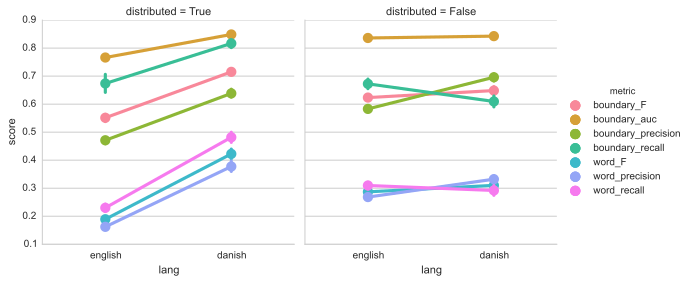

In [106]:
mdf = pd.melt(seg_df, id_vars=['lang', 'distributed'], var_name='metric', value_name='score')
sns.factorplot('lang', 'score', hue='metric', data=mdf, col='distributed')
sns.plt.savefig('figs/segmentation.pdf')

/Users/fred/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


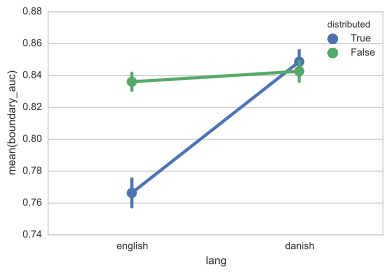

In [107]:
sns.pointplot('lang', 'boundary_auc', hue='distributed', data=seg_df, dodge=False)
sns.plt.savefig('figs/segmentation_roc.pdf')

# Experiment

In [110]:
def logistic(x, steepness=1):
    x = np.array(x)
    return 1. / (1. + np.exp(-steepness * (x)))

def get_network_choices(trial_errors):
    """Returns ([int], [float]): choices and reaction time
    choices is a list of 0 or 1 corresponding to word indices in one trial
    reaction time is a list of floats

    Args:
      trial_errors [(float, float)]: each tuple represents
        the reaction times for the two words in a trial
    """    

    def choose(pair):
        pair = list(map(float, pair))  # REMOVE
        error_diff = pair[0] - pair[1]
        threshold = logistic(error_diff, 0.1)
        choice =  0 if np.random.random() > threshold else 1
        # Reaction time is inverse of percentage difference between values.
        rt = 1 / (abs(pair[0]-pair[1]) / (sum(pair)/2))
        return (choice, rt)

    results = [choose(p) for p in trial_errors]
    choices = [r[0] for r in results]
    reaction_times = [r[1] for r in results]
    return choices, reaction_times

In [111]:
# Get index of correct word for each trial.
with open('experiment/answer-key.txt', 'r') as f:
    key = [int(k) for k in f.read().split('\n')]

In [112]:
def run_experiment(errors):
    # Get net choices by comparing errors of each pair of words.
    trial_errors = [(errors[i], errors[i+1])
                    for i in range(0, len(errors), 2)]
    choices, reaction_times = get_network_choices(trial_errors)
    
    # Compare net choices to the key.
    incorrect = [i for i in range(len(choices))
                 if choices[i] != key[i]]
    accuracy = 1 - (len(incorrect) / len(choices))
    
    # TODO: reaction times.
    correct_reaction_times = [t for i, t in enumerate(reaction_times)
                              if i not in incorrect]
    reaction = sum(correct_reaction_times) / len(correct_reaction_times)
    return accuracy

In [143]:
exp_df = df[['distributed', 'lang']].copy()
exp_df['contoid'] = df['exp_a_errors'].apply(run_experiment)
exp_df['vocoid'] = df['exp_b_errors'].apply(run_experiment)

       a    b    c
0      0    0    0
1      1    1    1
2      2    2    2
3      3    3    3
4      4    4    4
5      5    5    5
6      6    6    6
7      7    7    7
8      8    8    8
9      9    9    9
10    10   10   10
11    11   11   11
12    12   12   12
13    13   13   13
14    14   14   14
15    15   15   15
16    16   16   16
17    17   17   17
18    18   18   18
19    19   19   19
20    20   20   20
21    21   21   21
22    22   22   22
23    23   23   23
24    24   24   24
25    25   25   25
26    26   26   26
27    27   27   27
28    28   28   28
29    29   29   29
..   ...  ...  ...
970  970  970  970
971  971  971  971
972  972  972  972
973  973  973  973
974  974  974  974
975  975  975  975
976  976  976  976
977  977  977  977
978  978  978  978
979  979  979  979
980  980  980  980
981  981  981  981
982  982  982  982
983  983  983  983
984  984  984  984
985  985  985  985
986  986  986  986
987  987  987  987
988  988  988  988
989  989  989  989
990  990  99

KeyError: 'exp_a_errors'

In [140]:
df = pd.DataFrame({'a': list(range(1000)), 'b': list(range(1000)), 'c': list(range(1000))})
df_view = df[['a', 'b']]
df_view['c'] = list(range(1000))


/Users/fred/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


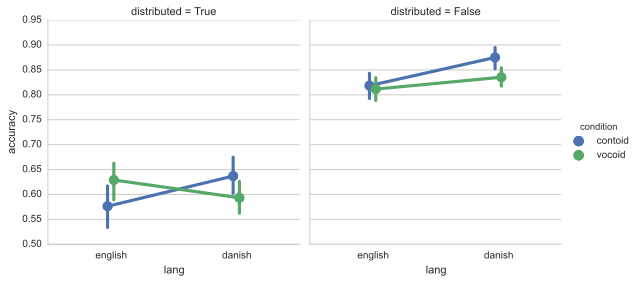

In [133]:
mdf = pd.melt(exp_df, ['lang', 'distributed'], var_name='condition', value_name='accuracy')
sns.factorplot('lang', 'accuracy', hue='condition', col='distributed', data=mdf, dodge=True)
sns.plt.savefig('figs/experiment.pdf')